installing dependencies

In [1]:
!pip install transformers scikit-learn pandas


DEPRECATION: scispacy 0.3.0 has a non-standard dependency specifier requests<3.0.0conllu,>=2.0.0. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of scispacy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
!pip install datasets

DEPRECATION: scispacy 0.3.0 has a non-standard dependency specifier requests<3.0.0conllu,>=2.0.0. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of scispacy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
!pip install torch

DEPRECATION: scispacy 0.3.0 has a non-standard dependency specifier requests<3.0.0conllu,>=2.0.0. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of scispacy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
!pip install -U accelerate

  Using cached accelerate-0.31.0-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-0.31.0-py3-none-any.whl (309 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.10.0
    Uninstalling accelerate-0.10.0:
      Successfully uninstalled accelerate-0.10.0


DEPRECATION: scispacy 0.3.0 has a non-standard dependency specifier requests<3.0.0conllu,>=2.0.0. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of scispacy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [5]:
!pip install transformers==4.28.0 accelerate==0.10.0

  Using cached accelerate-0.10.0-py3-none-any.whl.metadata (14 kB)
Using cached accelerate-0.10.0-py3-none-any.whl (117 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.31.0
    Uninstalling accelerate-0.31.0:
      Successfully uninstalled accelerate-0.31.0


DEPRECATION: scispacy 0.3.0 has a non-standard dependency specifier requests<3.0.0conllu,>=2.0.0. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of scispacy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


importing required libraries

In [6]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools

c:\Users\MANISH\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading tner/bc5cdr dataset , defining their labels , and loading SciBERT tokenizer and model

In [7]:
# Load the BC5CDR dataset
dataset = load_dataset("tner/bc5cdr")

# Define the label mapping
label_mapping = {
    'O': 0,
    'B-CHEMICAL': 1,
    'I-CHEMICAL': 2,
    'B-DISEASE': 3,
    'I-DISEASE': 4
}
id_to_label = {v: k for k, v in label_mapping.items()}

# Load the SciBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
model = AutoModelForTokenClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=len(label_mapping))


c:\Users\MANISH\AppData\Local\Programs\Python\Python38\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPr

preprocessing of data (tokenization and label assignment)

In [8]:

# Preprocess the dataset
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples['tokens'], truncation=True, is_split_into_words=True, padding=True)
    labels = []
    for i, label in enumerate(examples['tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label[word_idx] != -100 else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized data

In [9]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map: 100%|██████████| 5330/5330 [00:01<00:00, 2668.47 examples/s]


importing required libraries for training 

In [10]:
import torch
from torch import nn
import numpy as np
from transformers import TrainingArguments, Trainer


defining training arguments with epoch 0.1

In [26]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=0.1,
    weight_decay=0.01,
)


compute metric function for evaluation during training

In [12]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_labels = [[id_to_label[l] for l in label if l != -100] for label in labels]
    true_predictions = [[id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
                        for prediction, label in zip(predictions, labels)]
    
    # flattening of list
    true_entities = list(itertools.chain(*true_labels))
    predicted_entities = list(itertools.chain(*true_predictions))
    
    accuracy = accuracy_score(true_entities, predicted_entities)
    precision = precision_score(true_entities, predicted_entities, average='weighted', zero_division=0)
    recall = recall_score(true_entities, predicted_entities, average='weighted', zero_division=0)
    f1 = f1_score(true_entities, predicted_entities, average='weighted', zero_division=0)
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

initializing trainer object

In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorForTokenClassification(tokenizer),
)

train the "allenai/scibert_scivocab_uncased" model on epoch 0.1

In [29]:
# # Train the model
# trainer.train()

c:\Users\MANISH\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.














































































































































































































































































































































                                      
                                            

  0%|        

{'eval_loss': 0.32251405715942383, 'eval_accuracy': 0.8932618658965344, 'eval_precision': 0.8582698923973178, 'eval_recall': 0.8932618658965344, 'eval_f1': 0.8648299985323795, 'eval_runtime': 2368.289, 'eval_samples_per_second': 2.251, 'eval_steps_per_second': 0.141, 'epoch': 0.1}
{'train_runtime': 3073.3363, 'train_samples_per_second': 0.17, 'train_steps_per_second': 0.011, 'train_loss': 0.5487225850423177, 'epoch': 0.1}


TrainOutput(global_step=33, training_loss=0.5487225850423177, metrics={'train_runtime': 3073.3363, 'train_samples_per_second': 0.17, 'train_steps_per_second': 0.011, 'train_loss': 0.5487225850423177, 'epoch': 0.1})

saving the model and tokenizer (trained on epoch 0.1)

In [32]:
# # Save the trained model and tokenizer
# output_dir = "D:\\ML projects\\internship work nith\\trained_model_scibert"
# model.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)
# print(f"Model and tokenizer saved to {output_dir}")


Model and tokenizer saved to D:\ML projects\internship work nith\trained_model_scibert


loading trained model and tokenizer

In [33]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Load the saved model and tokenizer
model_path = "D:\\ML projects\\internship work nith\\trained_model_scibert"
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)
loaded_model = AutoModelForTokenClassification.from_pretrained(model_path)
print("Model and tokenizer loaded successfully")


Model and tokenizer loaded successfully


initializing trainer with loaded model (trained model) for evaluation on test data

In [34]:
# Evaluate the loaded model on the test dataset
trainer = Trainer(
    model=loaded_model,
    args=training_args,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=loaded_tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorForTokenClassification(loaded_tokenizer),
)

prediction on test data

In [35]:
# Evaluate the model on the test dataset
test_results = trainer.predict(tokenized_datasets["test"])

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 367/367 [28:01<00:00,  4.58s/it]


In [36]:
# Get the predictions and true labels
predictions = np.argmax(test_results.predictions, axis=2)
true_labels = [[id_to_label[l] for l in label if l != -100] for label in test_results.label_ids]
true_predictions = [[id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
                    for prediction, label in zip(predictions, test_results.label_ids)]

# Flatten the lists for metric calculation
true_entities = list(itertools.chain(*true_labels))
predicted_entities = list(itertools.chain(*true_predictions))

compute evaluation metrics 

In [37]:
# Calculate metrics
accuracy = accuracy_score(true_entities, predicted_entities)
precision = precision_score(true_entities, predicted_entities, average='weighted', zero_division=0)
recall = recall_score(true_entities, predicted_entities, average='weighted', zero_division=0)
f1 = f1_score(true_entities, predicted_entities, average='weighted', zero_division=0)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8988
Precision: 0.8645
Recall: 0.8988
F1 Score: 0.8711


initializing training argument for epoch 3

In [11]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)


In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorForTokenClassification(tokenizer),
)

training of model on epoch 3

In [14]:
# # # Train the model
# trainer.train()

c:\Users\MANISH\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/981 [00:00<?, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
                                                     
 33%|███▎      | 327/981 [2:55:05<5:48:59, 32.02s/it]

{'eval_loss': 0.10627762228250504, 'eval_accuracy': 0.964724070818684, 'eval_precision': 0.9655418189038097, 'eval_recall': 0.964724070818684, 'eval_f1': 0.9650272945374362, 'eval_runtime': 3572.5795, 'eval_samples_per_second': 1.492, 'eval_steps_per_second': 0.093, 'epoch': 1.0}


 51%|█████     | 500/981 [4:45:40<4:16:24, 31.98s/it]    

{'loss': 0.1309, 'learning_rate': 9.80632008154944e-06, 'epoch': 1.53}


                                                     
 67%|██████▋   | 654/981 [9:21:07<1:45:26, 19.35s/it]

{'eval_loss': 0.10137002915143967, 'eval_accuracy': 0.9675257408337519, 'eval_precision': 0.9689198596759274, 'eval_recall': 0.9675257408337519, 'eval_f1': 0.9680714063992023, 'eval_runtime': 12632.949, 'eval_samples_per_second': 0.422, 'eval_steps_per_second': 0.026, 'epoch': 2.0}


                                                         
100%|██████████| 981/981 [12:14:28<00:00, 44.92s/it]


{'eval_loss': 0.10657764226198196, 'eval_accuracy': 0.9702018458061276, 'eval_precision': 0.9706099172251962, 'eval_recall': 0.9702018458061276, 'eval_f1': 0.9703722441545526, 'eval_runtime': 3164.6852, 'eval_samples_per_second': 1.684, 'eval_steps_per_second': 0.106, 'epoch': 3.0}
{'train_runtime': 44068.0738, 'train_samples_per_second': 0.356, 'train_steps_per_second': 0.022, 'train_loss': 0.0872931601925849, 'epoch': 3.0}


TrainOutput(global_step=981, training_loss=0.0872931601925849, metrics={'train_runtime': 44068.0738, 'train_samples_per_second': 0.356, 'train_steps_per_second': 0.022, 'train_loss': 0.0872931601925849, 'epoch': 3.0})

saving the model and tokenizer (trained on epoch 3)

In [15]:
# # # Save the trained model and tokenizer
# output_dir = "D:\\ML projects\\internship work nith\\trained_model_scibert_3"
# model.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)
# print(f"Model and tokenizer saved to {output_dir}")


Model and tokenizer saved to D:\ML projects\internship work nith\trained_model_scibert_3


loading the model and tokenizer (trained on epoch 3)

In [16]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

# Load the saved model and tokenizer
model_path = "D:\\ML projects\\internship work nith\\trained_model_scibert_3"
loaded_tokenizer_3 = AutoTokenizer.from_pretrained(model_path)
loaded_model_3 = AutoModelForTokenClassification.from_pretrained(model_path)
print("Model and tokenizer loaded successfully")


Model and tokenizer loaded successfully


initializing trainer object with trained model (epoch 3)

In [17]:
# Evaluate the loaded model on the test dataset
trainer = Trainer(
    model=loaded_model_3,
    args=training_args,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=loaded_tokenizer_3,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorForTokenClassification(loaded_tokenizer_3),
)

prediction on test data 

In [18]:
# Evaluate the model on the test dataset
test_result = trainer.predict(tokenized_datasets["test"])

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 367/367 [11:43:49<00:00, 115.07s/it]      


In [22]:
# Get the predictions and true labels
predictions = np.argmax(test_result.predictions, axis=2)
true_labels = [[id_to_label[l] for l in label if l != -100] for label in test_result.label_ids]
true_predictions = [[id_to_label[p] for (p, l) in zip(prediction, label) if l != -100]
                    for prediction, label in zip(predictions, test_result.label_ids)]

# Flatten the lists for metric calculation
true_entity = list(itertools.chain(*true_labels))
predicted_entity = list(itertools.chain(*true_predictions))

evaluation metrics

In [23]:
# Calculate metrics
Accuracy = accuracy_score(true_entity, predicted_entity)
Precision = precision_score(true_entity, predicted_entity, average='weighted', zero_division=0)
Recall = recall_score(true_entity, predicted_entity, average='weighted', zero_division=0)
F1 = f1_score(true_entity, predicted_entity, average='weighted', zero_division=0)

# Print the metrics
print(f"Accuracy: {Accuracy:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall: {Recall:.4f}")
print(f"F1 Score: {F1:.4f}")

Accuracy: 0.9678
Precision: 0.9686
Recall: 0.9678
F1 Score: 0.9681


visualizing the results on different epoch size 

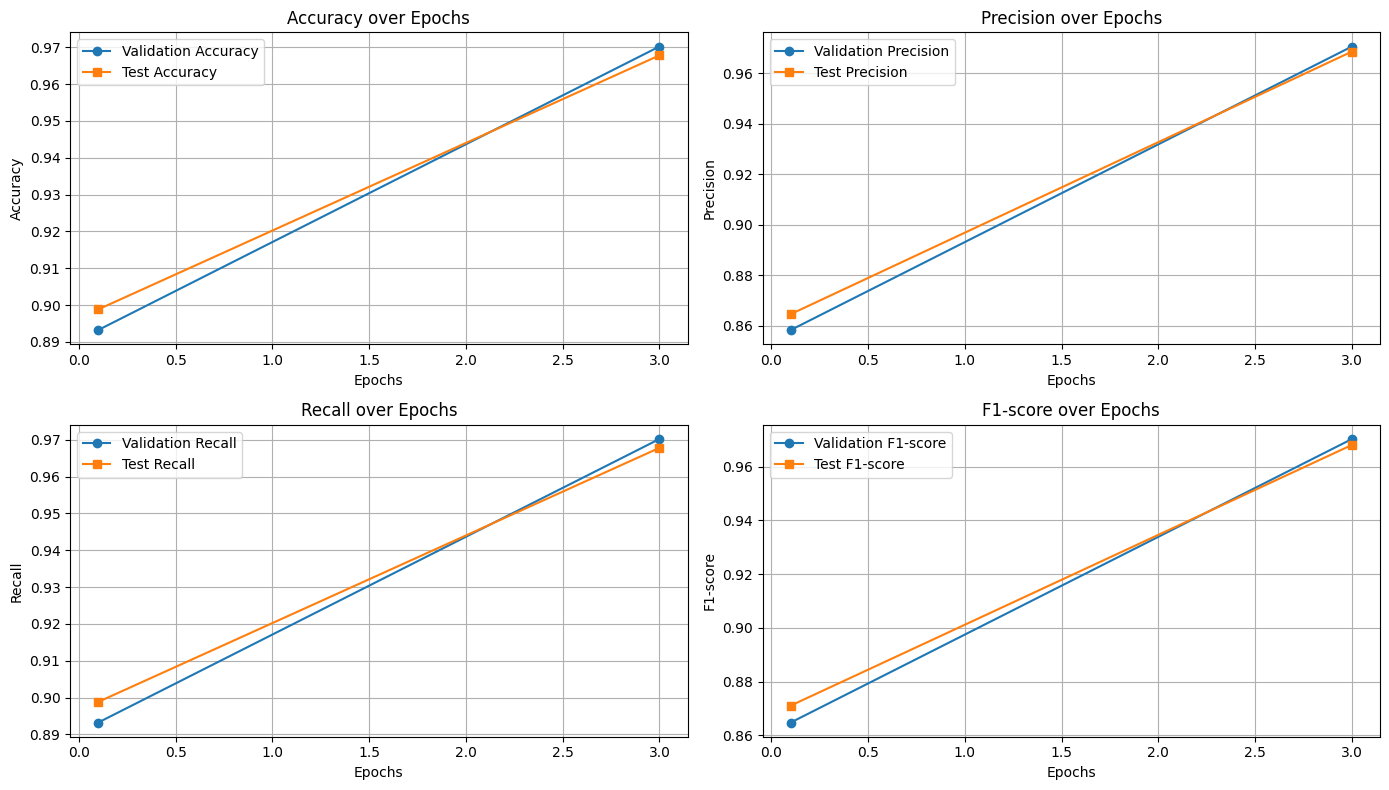

In [2]:
import matplotlib.pyplot as plt

# Epochs
epochs = [0.1,3]

# Validation metrics
val_accuracy = [0.8932,0.9702]
val_precision = [0.8582,0.9706]
val_recall = [0.8932,0.9702]
val_f1score = [0.8648,0.9703]

# Test metrics
test_accuracy = [0.8988,0.9678]
test_precision = [0.8645,0.9686]
test_recall = [0.8988,0.9678]
test_f1score = [0.8711,0.9681]


# Plotting the metrics
plt.figure(figsize=(14, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, val_accuracy, 'o-', label='Validation Accuracy')
plt.plot(epochs, test_accuracy, 's-', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(epochs, val_precision, 'o-', label='Validation Precision')
plt.plot(epochs, test_precision, 's-', label='Test Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, val_recall, 'o-', label='Validation Recall')
plt.plot(epochs, test_recall, 's-', label='Test Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall over Epochs')
plt.legend()
plt.grid(True)

# F1-score
plt.subplot(2, 2, 4)
plt.plot(epochs, val_f1score, 'o-', label='Validation F1-score')
plt.plot(epochs, test_f1score, 's-', label='Test F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('F1-score over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
